### Code Hist.

 - CODE  
    &ensp; : Crawling - 특일 정보 조회 (KASI)

  - DATE  
    &ensp; 2023-11-29 Created  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1)   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2)   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 3)   
    
 - DESC  
    &ensp; : 전처리 - 한국지역난방공사 열판매량/열공급량   
    &emsp; 1) 결측치가 없어서, 그대로 사용  
    &emsp;&ensp;&ensp; 
    &emsp;&ensp;&ensp; (Crawl Code 없음)   
    &emsp; 2) 

 - DATA  
    &emsp; <"Input">  
    1) None (Input Dataset)  
    &emsp;- Period :   
    &emsp;- Interval : 

    &emsp; <"Output">  
    1) Hourly (관측소/년도별 출력)  
    &nbsp;df_data_cal.to_csv(data_dir + 'KASI_DATE_D_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    2) Daily (관측소/년도별 출력)  
    &nbsp;df_data_cal_24.to_csv(data_dir + 'KASI_DATE_H_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['locdate', 'YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'HOUR', 'MINUTE']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    

 - Related Link  
    &ensp; : 

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [1]:
#region Basic_Import
## Basic
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random
from pandas import DataFrame, Series

## Datetime
import time
import datetime as dt
from datetime import datetime, date, timedelta

import glob
from glob import glob
import requests
import json

## 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## TSNE
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

## 정규화
from sklearn.preprocessing import MinMaxScaler, StandardScaler
## PCA
from sklearn.decomposition import PCA

## Modeling, Model Training
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
## Model 평가
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score   # model.score   

## Excel/CSV
import openpyxl, xlrd

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [29]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch
    import torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf
    import tensorflow_addons as tfa
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [30]:
## Import_Local (현재 프로그램에서 미사용)
from DEV_Common_Data_Analysis import print_desc_statistic
from DEV_Common_Data_Datetime import create_col_ymdhm, create_col_datetime, create_df_dt, conv_midnight_24to00, create_col_weekdays #, validate_date, list_invalidDate, calc_df_dt
from DEV_Common_Data_Preprocessing import resample_by_last, find_outlier_Usages, del_outlier_Usages
from DEV_Common_Data_Visualization import visualization_df
from DEV_KASI_Holiday import KASI_holiDay, KASI_restDay, KASI_anniDay
from DEV_KMA_Weather_ASOS import KMA_ASOS_DATA
from DEV_KDHC_Usage import KDHC_HEAT_Usage

### 01-01-02. Config (Directory, Params)

In [31]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
random.seed(SEED)

In [32]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y = pd.datetime.now().year
str_now_m = pd.datetime.now().month
str_now_d = pd.datetime.now().day
str_now_hr = pd.datetime.now().hour
str_now_min = pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2023-12-28 17:47:53.558659
2023 / 12 / 28
17 : 47


## 01-02. Data Load (df_raw)

### 01-02-01. KDHC Heat Usage (Intergrated)

In [33]:
# Define data root directory
str_dir_kdhcHeat = "./data_Energy_KDHC_National_Heat/"
str_file = "KDHC_COMB_HEAT_2019-2022.csv"
print(os.listdir(str_dir_kdhcHeat))

df_kdhc_heat = pd.read_csv(str_dir_kdhcHeat + str_file, index_col = 0)
df_kdhc_heat['METER_DATE'] = pd.to_datetime(df_kdhc_heat['METER_DATE'])
df_kdhc_heat

['KDHC_COMB_HEAT-CJ_ASOS_KASI_2010-2023.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_complete_analysis.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_linearReg.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_mean_imp.csv', 'KDHC_COMB_HEAT_2019-2022.csv', 'KDHC_COMB_KANGNAMHEATxWEATHER_2019-2022.csv', 'KDHC_HEAT', 'KDHC_HEAT.zip', 'KDHC_HEAT_19Region_hr.csv', 'KDHC_HEAT_CHEONGJU_2010_2021.csv', 'KDHC_HEAT_CHEONGJU_2010_2021_1st_Check.csv', 'KDHC_HEAT_SEJONG_2014_2018.csv', 'KDHC_HEAT_SEJONG_2014_2018_1st_Check.csv', 'KDHC_NATIONAL_HEAT_hr.csv', 'KDHC_NATIONAL_HEAT_RAW_hr.csv']


,METER_DATE,PAJU,GOYANG,SAMSONG,JOONGANG,KANGNAM,PANGYO,BUNDANG,YONGIN,GWANGGYO,SUWON,HWASUNG,DONGTAN,PYONGTAEK,CHEONGJU,SEJONG,KIMHAE,DAEGU,YANGSAN,GWANGJU_JEONNAM
0,2019-10-01 01:00:00,20,73.0000000000,8.0000000000,20.0000000000,61.3000000000,8.0000000000,55.1000000000,30.0000000000,14.0000000000,26.0000000000,11.0000000000,21,0.5000000000,16,18.0000000000,8,19.0000000000,10,3
1,2019-10-01 01:00:00,20,73.0000000000,8.0000000000,20.0000000000,61.3000000000,8.0000000000,55.1000000000,30.0000000000,14.0000000000,26.0000000000,11.0000000000,21,0.5000000000,16,18.0000000000,8,19.0000000000,10,3
2,2019-10-01 02:00:00,15,65.0000000000,12.0000000000,18.0000000000,61.3000000000,4.0000000000,56.0000000000,25.0000000000,7.0000000000,29.0000000000,12.0000000000,16,0.5000000000,13,15.0000000000,7,16.0000000000,9,2
3,2019-10-01 02:00:00,15,65.0000000000,12.0000000000,18.0000000000,61.3000000000,4.0000000000,56.0000000000,25.0000000000,7.0000000000,29.0000000000,12.0000000000,16,0.5000000000,13,15.0000000000,7,16.0000000000,9,2
4,2019-10-01 03:00:00,14,58.0000000000,12.0000000000,17.0000000000,56.3000000000,5.0000000000,51.0000000000,18.0000000000,11.0000000000,33.0000000000,12.0000000000,14,0.5000000000,10,15.0000000000,7,15.0000000000,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27298,2022-09-30 20:00:00,41,81.0000000000,44.0000000000,45.0000000000,120.0000000000,37.0000000000,74.4000000000,87.0000000000,40.0000000000,73.0000000000,39.0000000000,61,12.0000000000,36,44.0000000000,12,30.0000000000,18,6
27299,2022-09-30 21:00:00,40,90.0000000000,46.0000000000,46.0000000000,112.0000000000,36.0000000000,78.4000000000,91.0000000000,25.0000000000,71.0000000000,36.0000000000,55,4.0000000000,30,44.0000000000,11,35.0000000000,22,5
27300,2022-09-30 22:00:00,37,95.0000000000,39.0000000000,44.0000000000,95.0000000000,24.0000000000,65.4000000000,81.0000000000,16.0000000000,65.0000000000,29.0000000000,45,2.0000000000,27,43.0000000000,12,32.0000000000,22,6
27301,2022-09-30 23:00:00,32,98.0000000000,35.0000000000,41.0000000000,89.0000000000,19.0000000000,51.4000000000,80.0000000000,16.0000000000,64.0000000000,25.0000000000,32,3.0000000000,25,40.0000000000,11,34.0000000000,22,6


In [34]:
## Date의 형식을 datetime으로 변경
date = pd.to_datetime(df_kdhc_heat['METER_DATE'])
date

0       2019-10-01 01:00:00
1       2019-10-01 01:00:00
2       2019-10-01 02:00:00
3       2019-10-01 02:00:00
4       2019-10-01 03:00:00
                ...        
27298   2022-09-30 20:00:00
27299   2022-09-30 21:00:00
27300   2022-09-30 22:00:00
27301   2022-09-30 23:00:00
27302   2022-10-01 00:00:00
Name: METER_DATE, Length: 27303, dtype: datetime64[ns]

In [35]:
df_kdhc_heat.columns

Index(['METER_DATE', 'PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG', 'KANGNAM',
       'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG',
       'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG', 'KIMHAE', 'DAEGU',
       'YANGSAN', 'GWANGJU_JEONNAM'],
      dtype='object')

===============  IQR Range =============== 
246.5
110.0
91.0
33.0
19.0
-117.5
===============  IQR Range =============== 
cnt_outlier = 0


===============  IQR Range =============== 
246.5
110.0
91.0
33.0
19.0
-117.5
===============  IQR Range =============== 
cnt_outlier = 0
0
===============  IQR Range =============== 
1130.0
500.0
420.0
154.0
80.0
-550.0
===============  IQR Range =============== 
cnt_outlier = 0
===============  IQR Range =============== 
1130.0
500.0
420.0
154.0
80.0
-550.0
===============  IQR Range =============== 
cnt_outlier = 0
0
===============  IQR Range =============== 
249.0
120.0
86.0
50.0
34.0
-95.0
===============  IQR Range =============== 
cnt_outlier = 0
===============  IQR Range =============== 
249.0
120.0
86.0
50.0
34.0
-95.0
===============  IQR Range =============== 
cnt_outlier = 0
0
===============  IQR Range =============== 
575.5
250.0
217.0
68.0
33.0
-292.5
===============  IQR Range =============== 
cnt_outlier = 0
===============  IQR Range =============== 
575.5
250.0
217.0
68.0
33.0
-292.5
===============  IQR Range =============== 
cnt_outlier = 0
0
===============  IQR

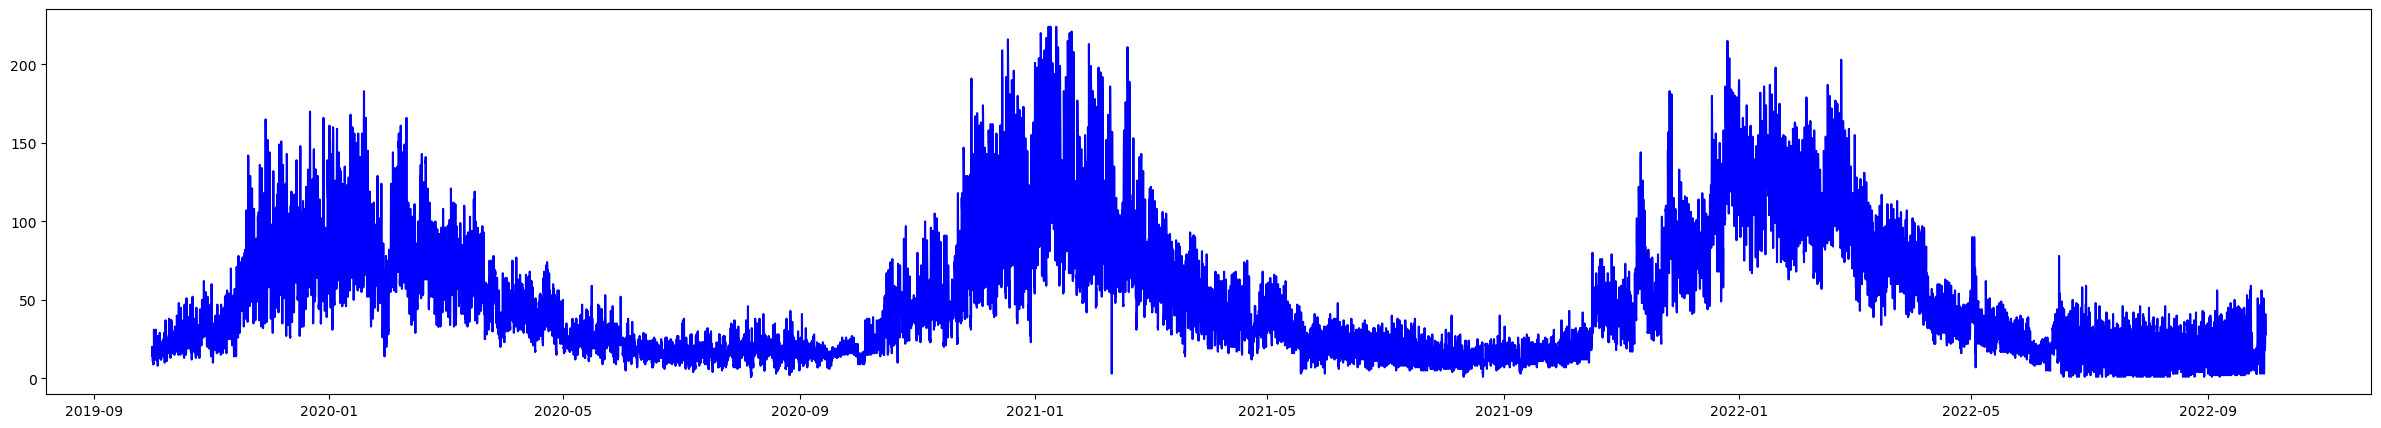

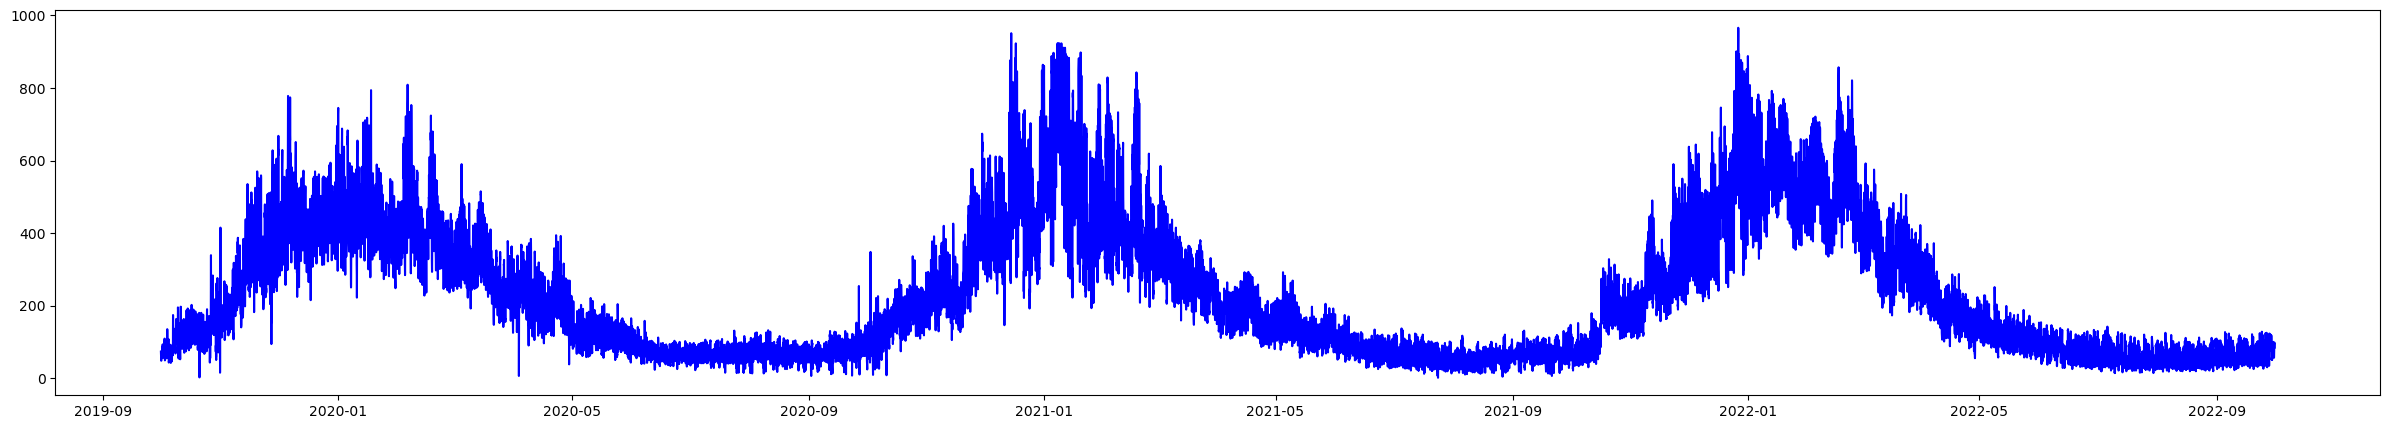

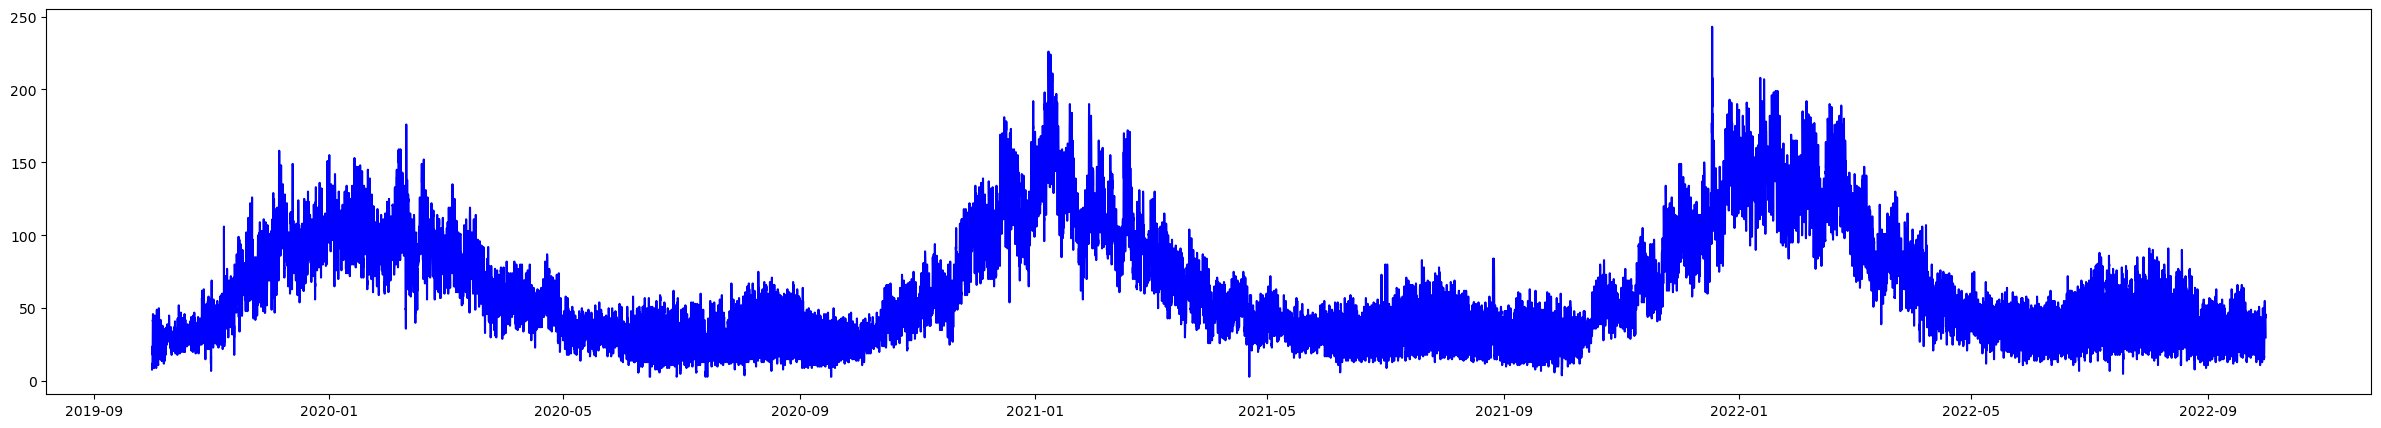

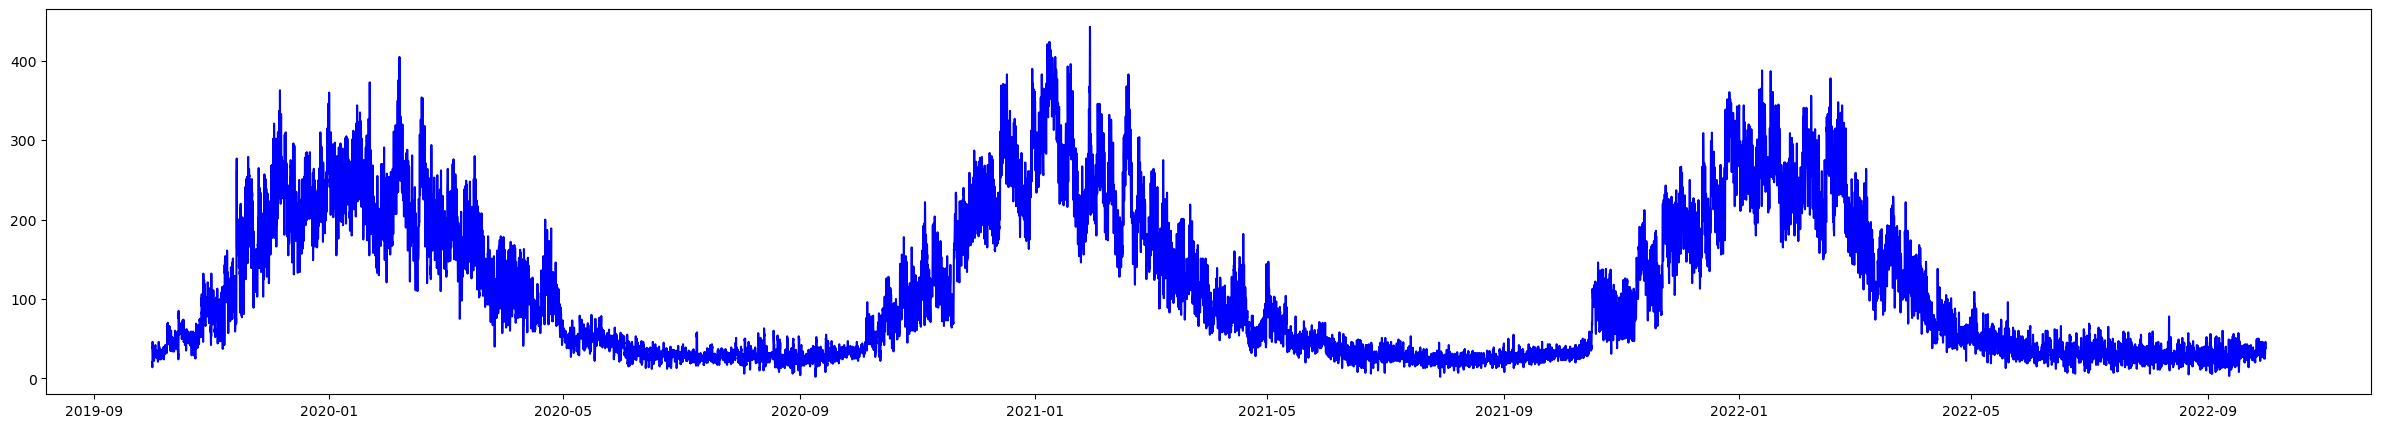

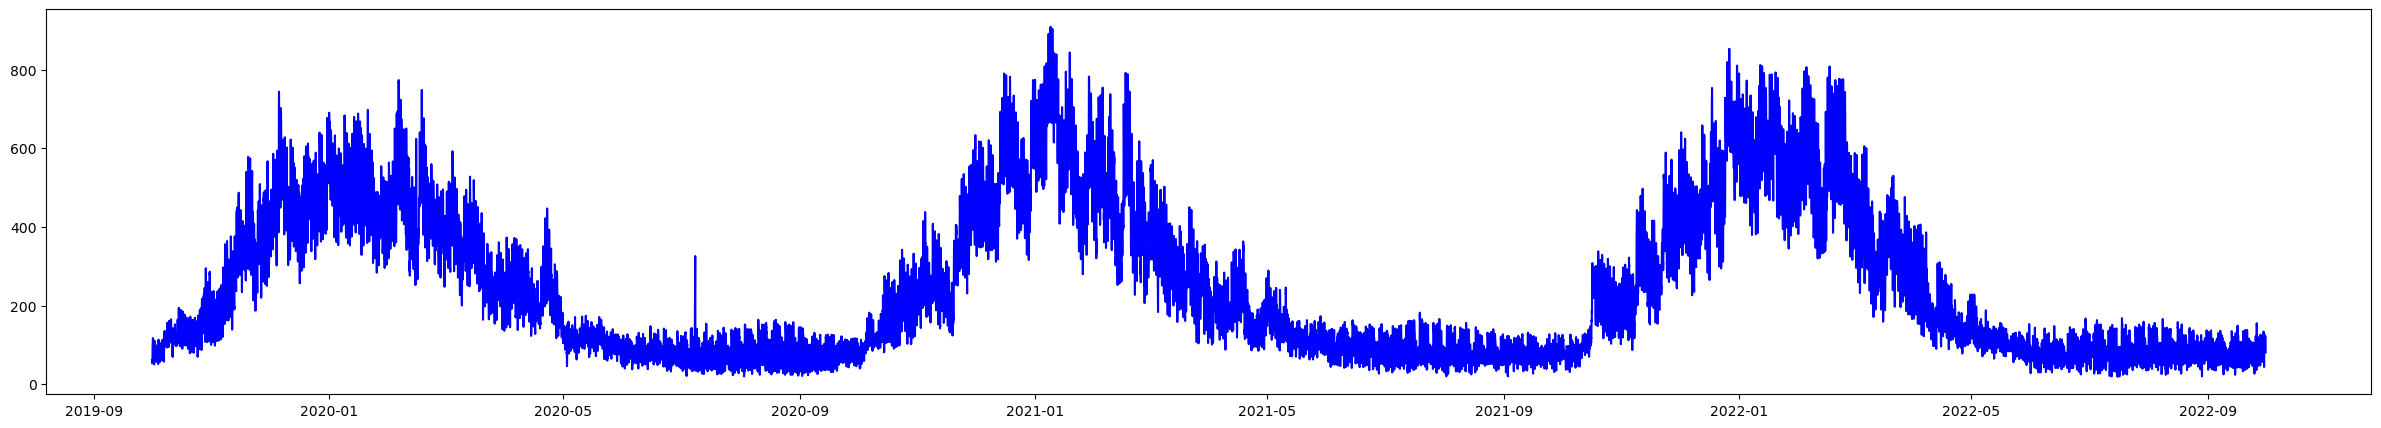

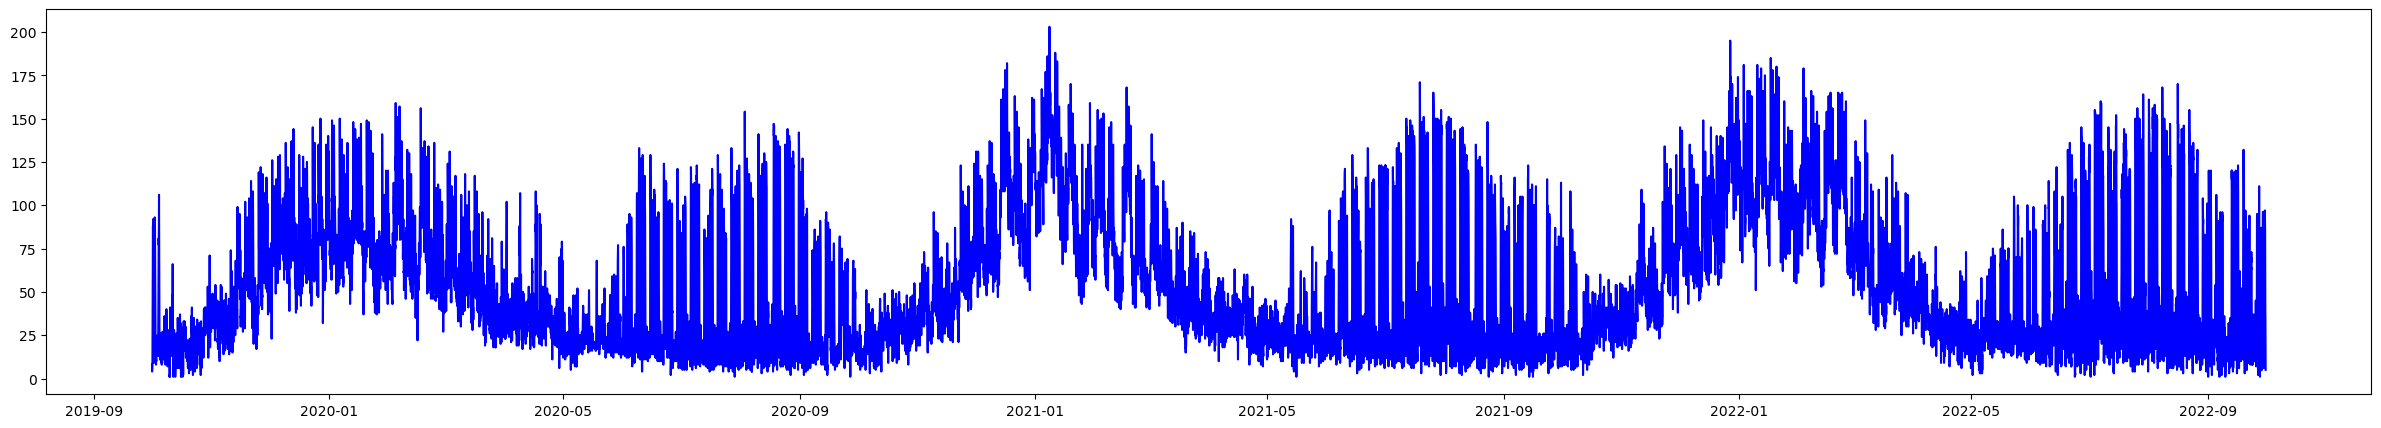

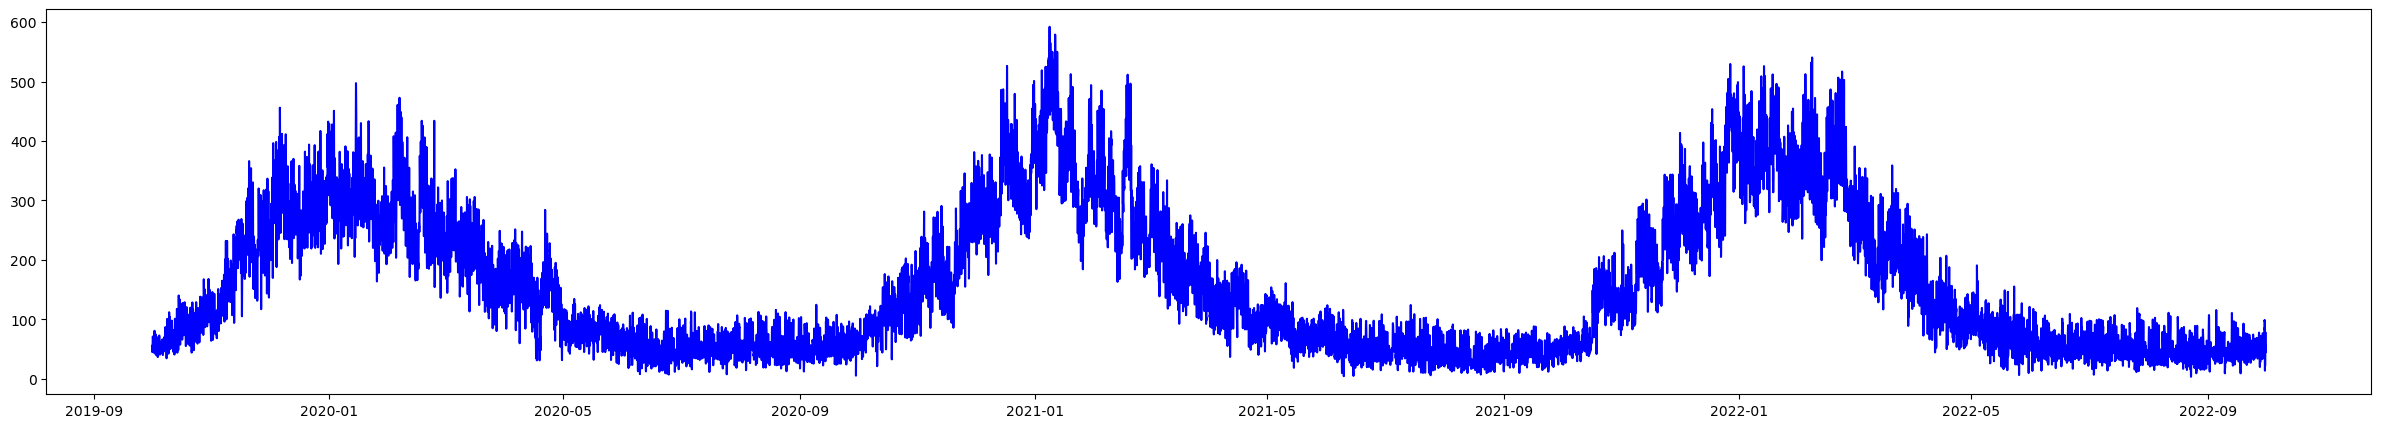

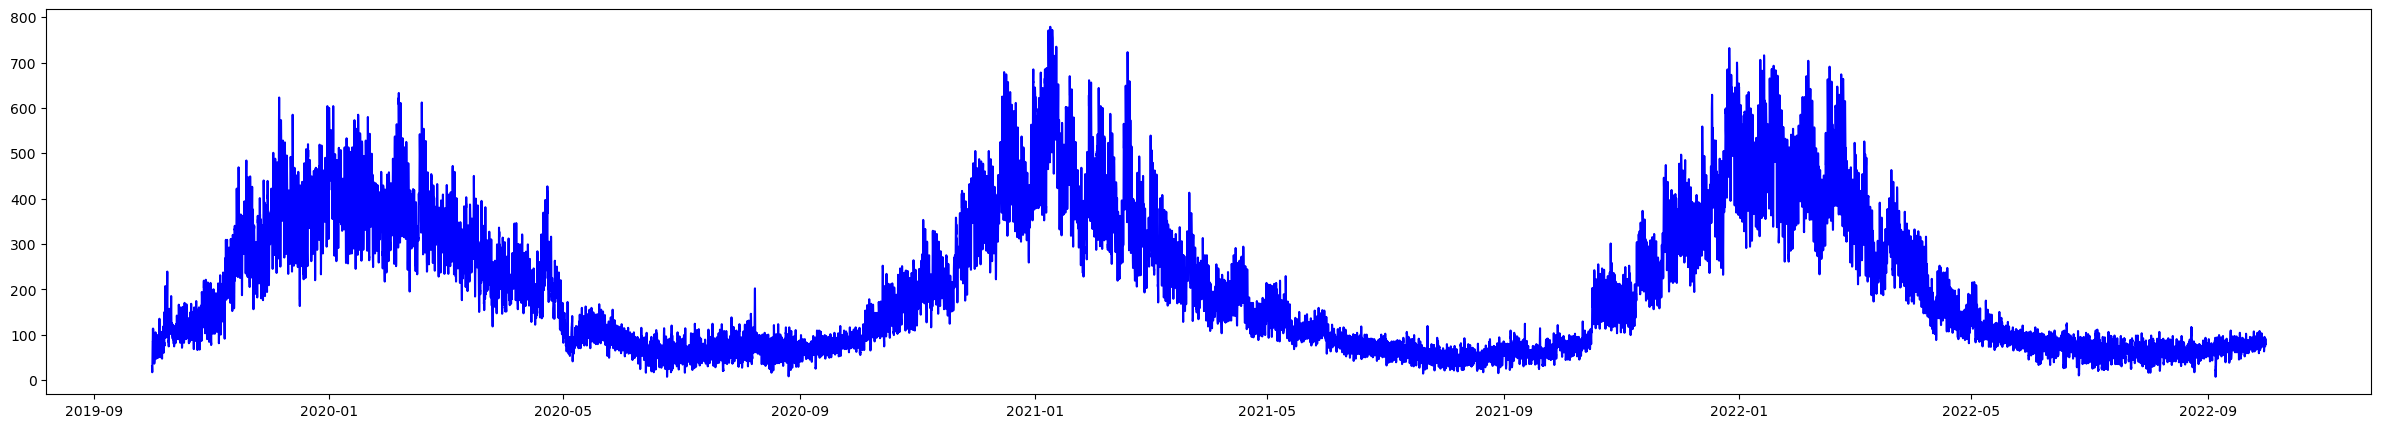

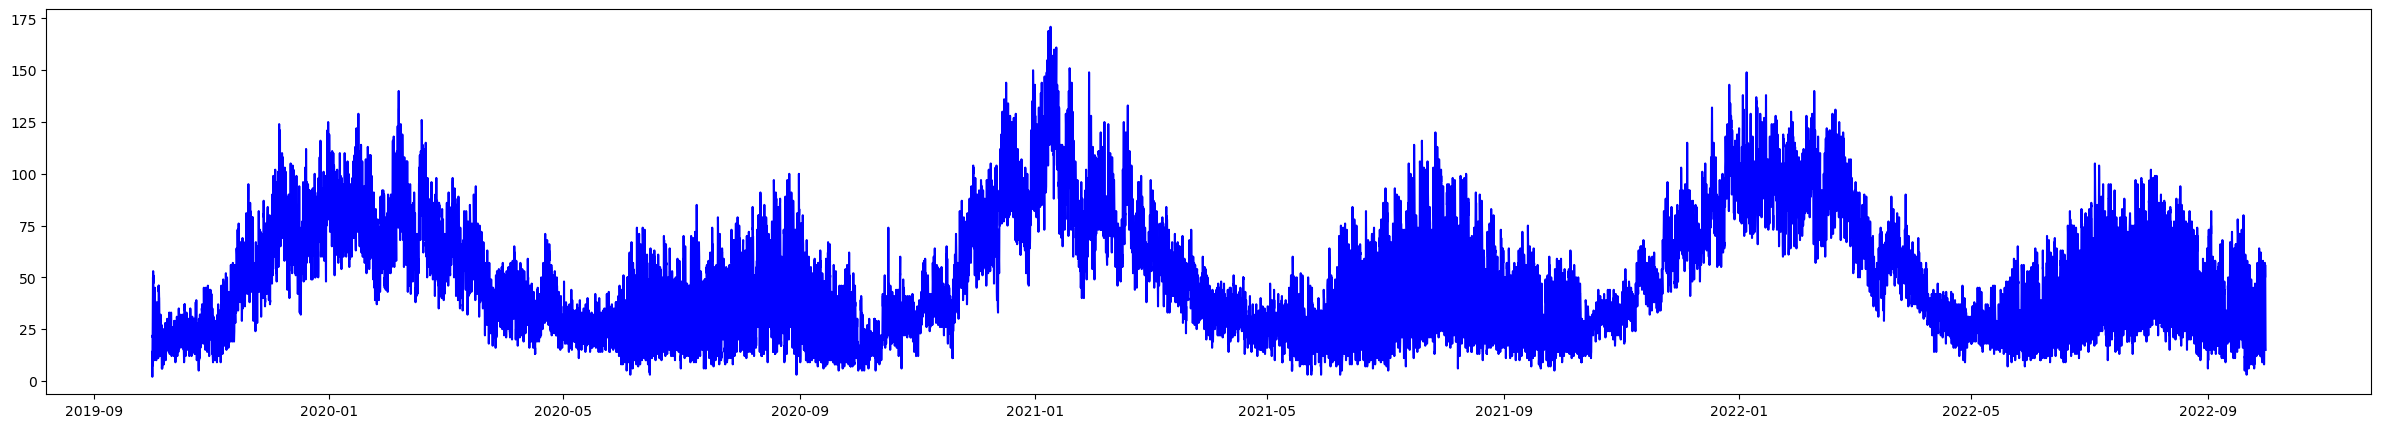

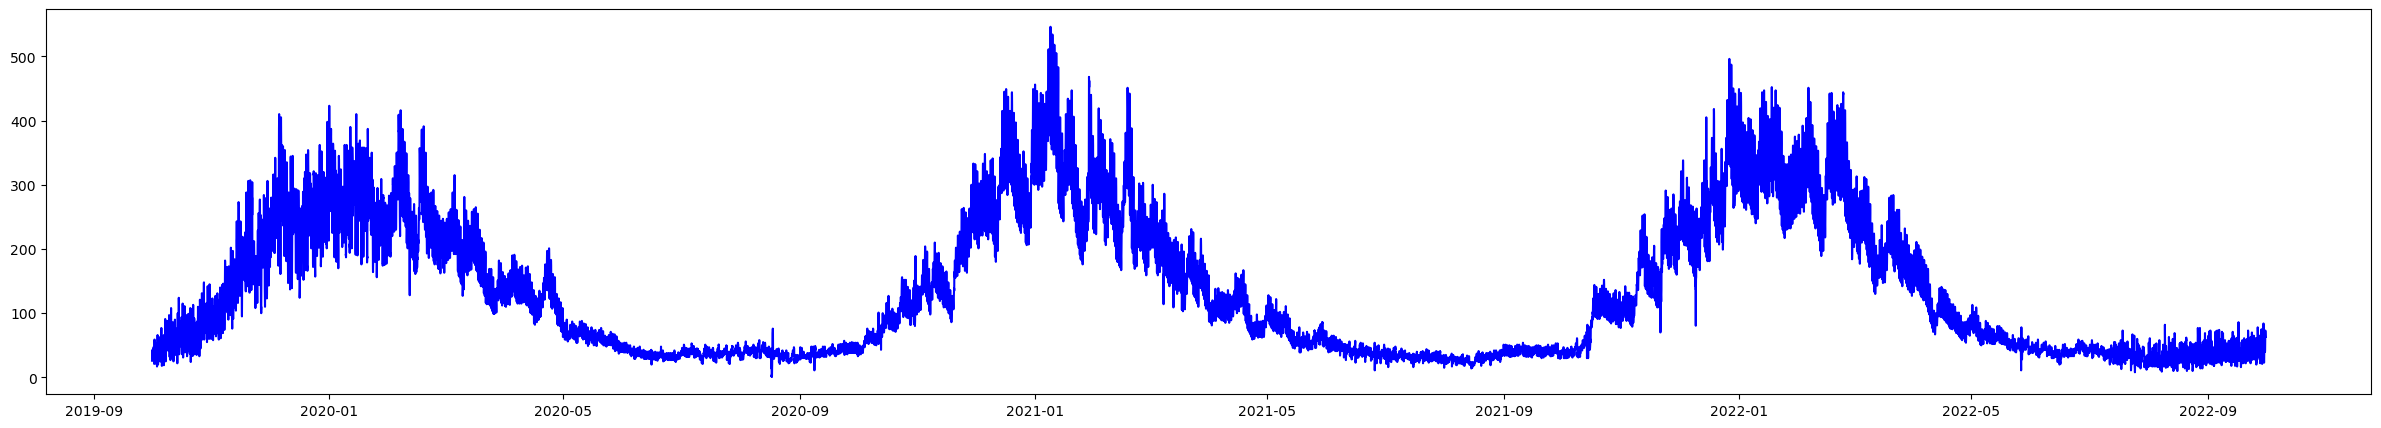

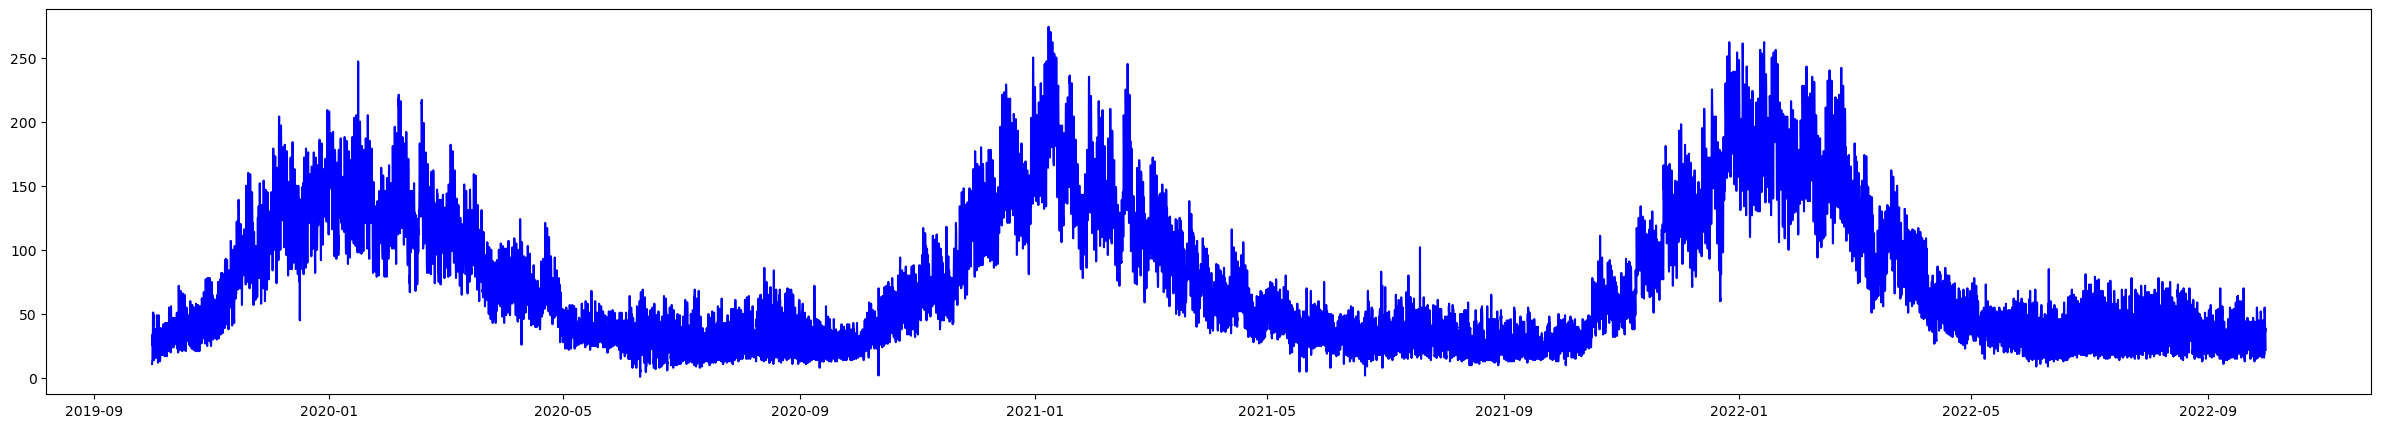

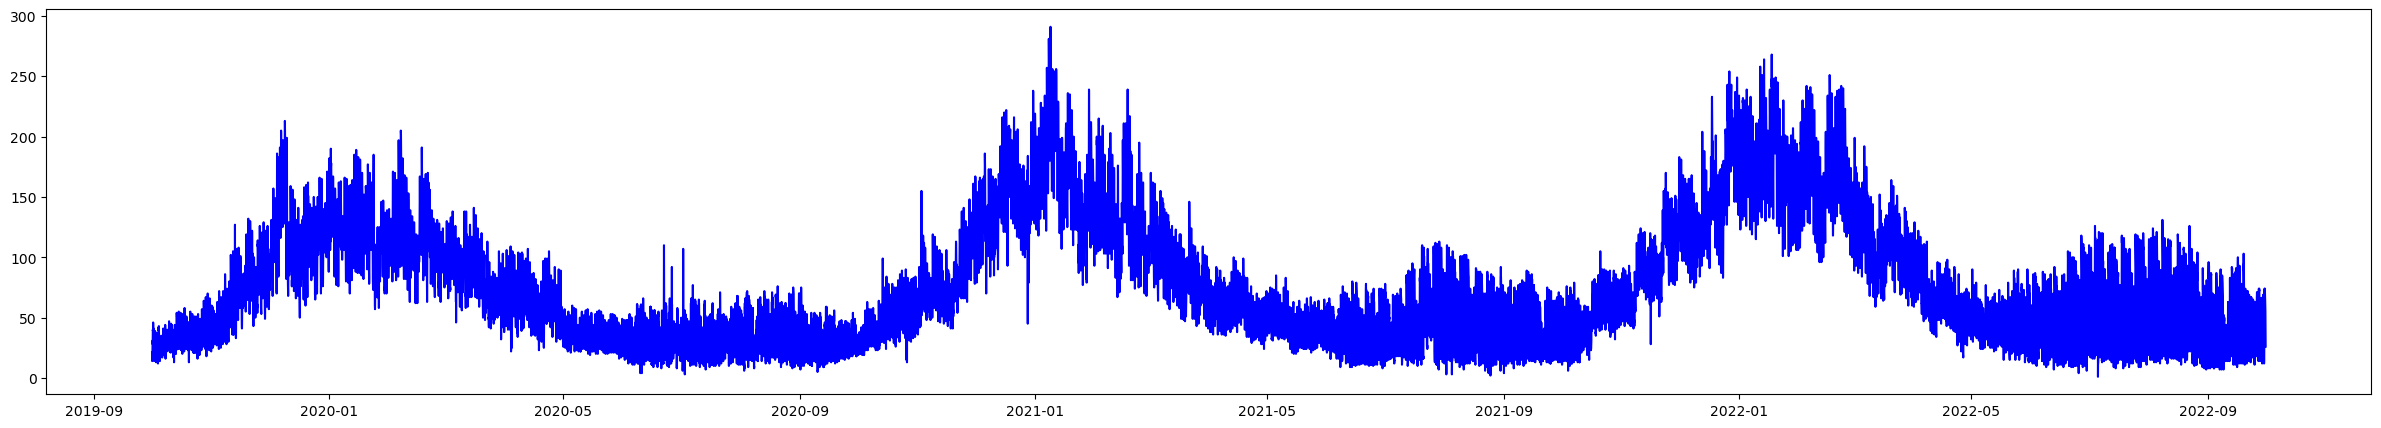

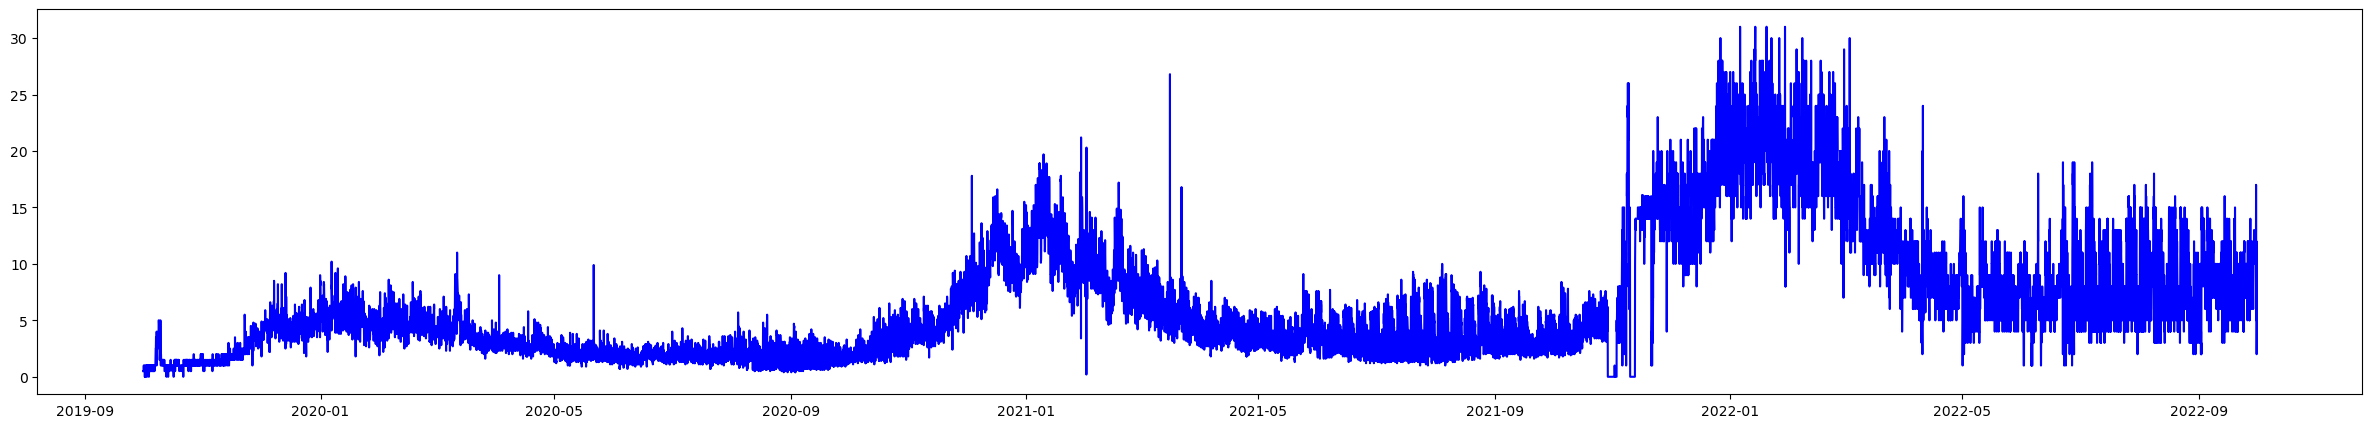

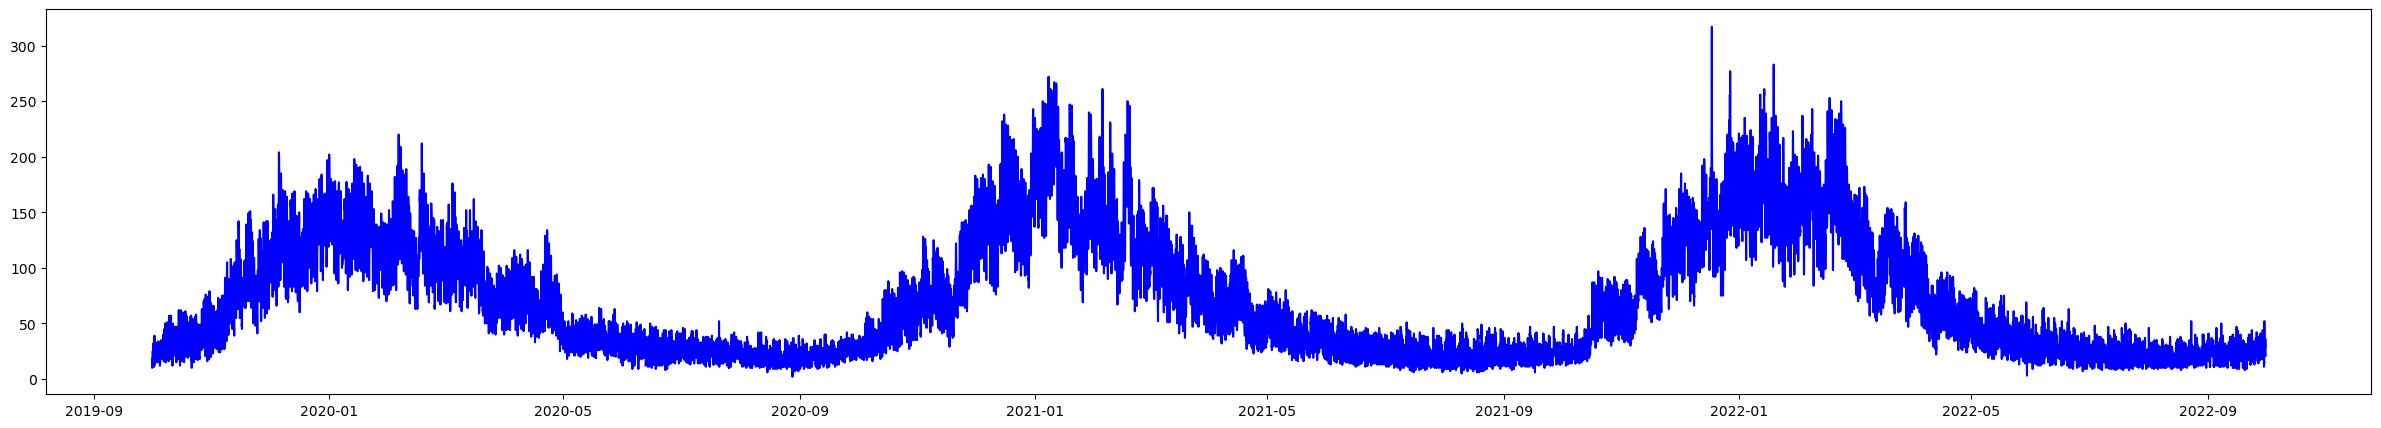

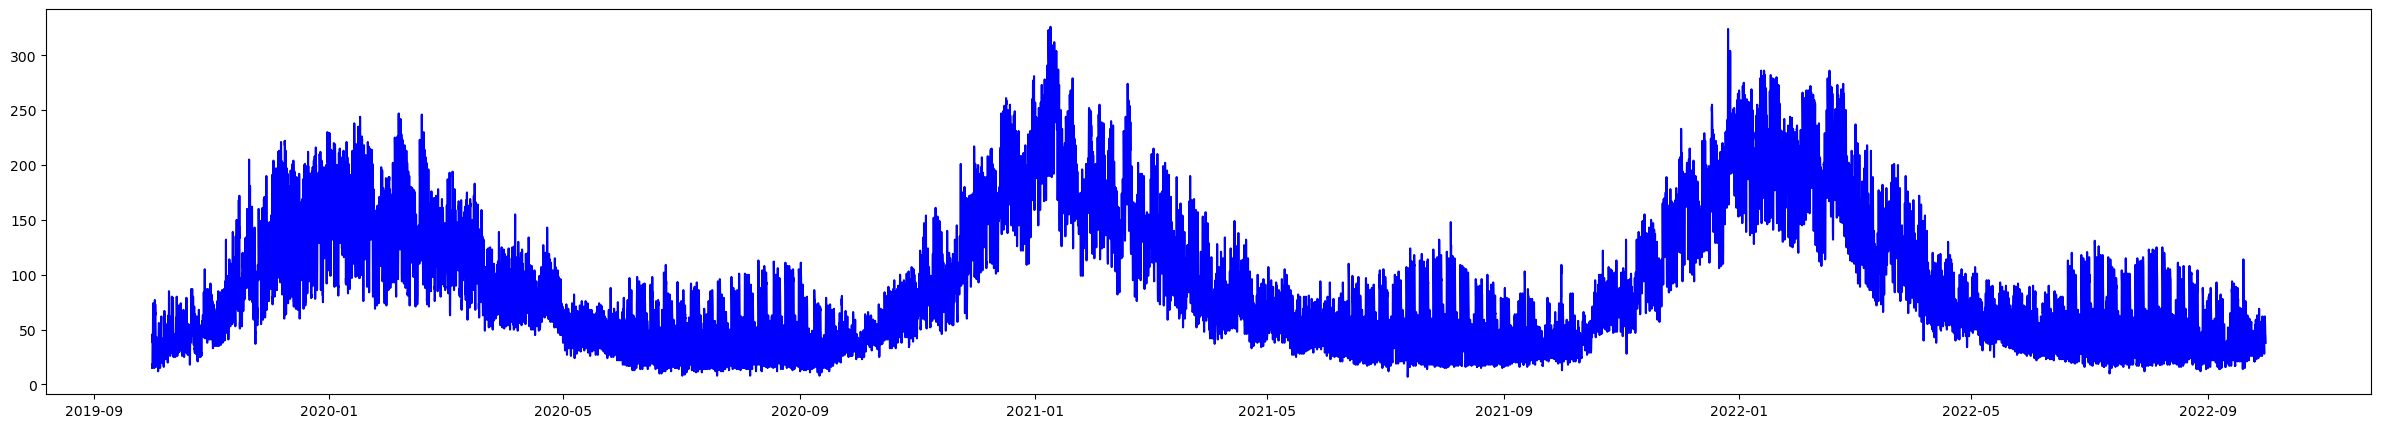

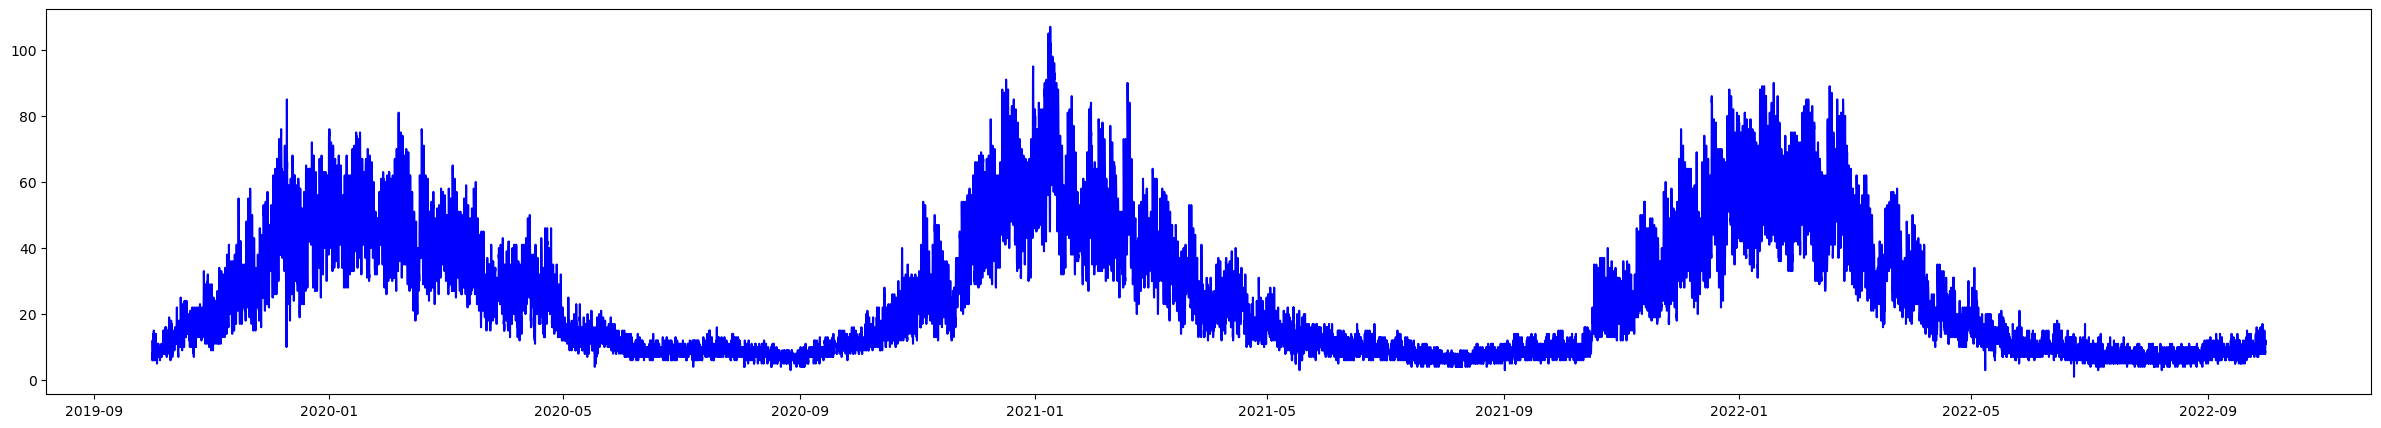

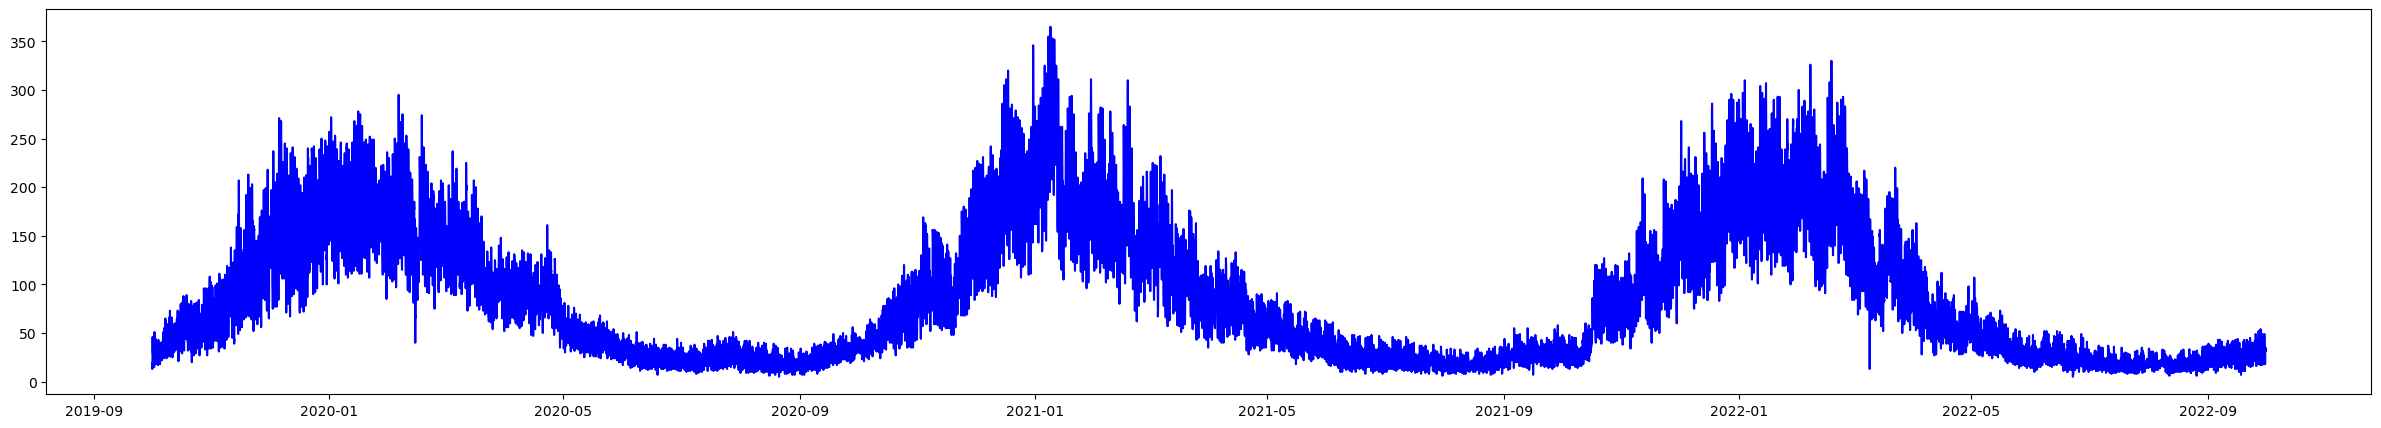

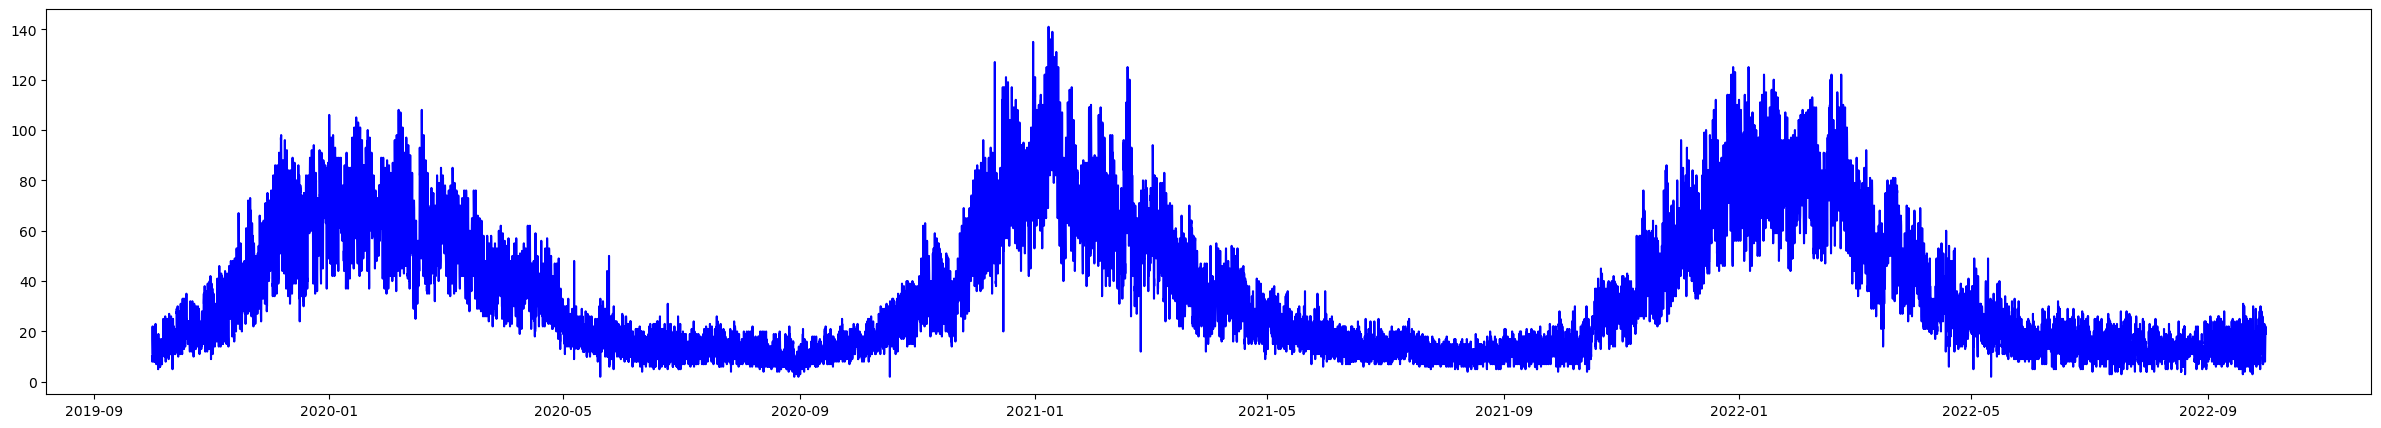

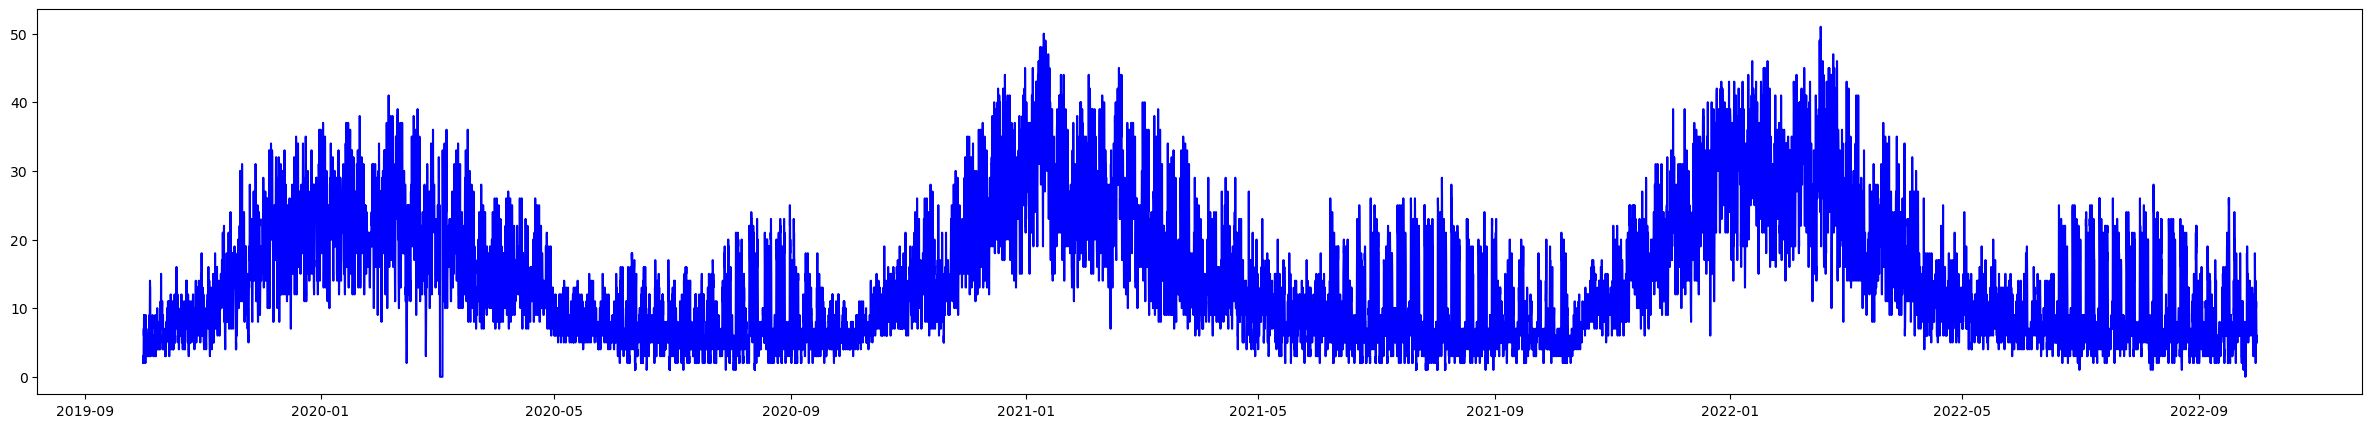

In [36]:
list_col = ['PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG'
            , 'KANGNAM'
            , 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG'
            , 'KIMHAE', 'DAEGU', 'YANGSAN'
            , 'GWANGJU_JEONNAM']

for col_tar in list_col:
    find_outlier_Usages(df_kdhc_heat, col_tar)
    del_outlier_Usages(df_kdhc_heat, col_tar)

for col_tar in list_col:
    ## 시각화
    fig, ax1 = plt.subplots(figsize=(30,5))
    ax1.plot(date, df_kdhc_heat[col_tar], color='blue')
    plt.show()

In [37]:
df_raw_temp = df_kdhc_heat

In [38]:
df_raw_temp.columns

Index(['METER_DATE', 'PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG', 'KANGNAM',
       'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG',
       'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG', 'KIMHAE', 'DAEGU',
       'YANGSAN', 'GWANGJU_JEONNAM'],
      dtype='object')

In [39]:
#X is feature vectors
X = df_raw_temp[['PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG'
                 , 'KANGNAM'
                 , 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG'
                 , 'KIMHAE', 'DAEGU', 'YANGSAN'
                 , 'GWANGJU_JEONNAM']]

# y is labels
# Y = df_raw_temp[['CHEONGJU']]

X_scaled = StandardScaler().fit_transform(X)
print(X_scaled.shape)
print(X_scaled[1].shape)

(27303, 19)
(19,)


In [40]:
pca = PCA(n_components = 3)

## Scaled Data -> PCA Transformed Data
pca.fit(X_scaled)
x_pca = pca.transform(X_scaled)

print(f"스케일 데이터 shape: {X_scaled.shape}")
print(f"PCA 데이터 shape: {x_pca.shape}")

스케일 데이터 shape: (27303, 19)
PCA 데이터 shape: (27303, 3)


In [47]:
# PCA 데이터 프레임 생성
pca_columns=['pca_component_1', 'pca_component_2', 'pca_component_3']

df_pca = pd.DataFrame(x_pca, columns = pca_columns)
# iris_df_pca['target'] = x_pca.target

df_pca.head(3)

,pca_component_1,pca_component_2,pca_component_3
0,-4.5486431464,-0.8102644725,0.0480436434
1,-4.5486431464,-0.8102644725,0.0480436434
2,-4.7385097055,-0.9486422792,0.1341413624


In [42]:
# Component 변동성 반영 비율
print(pca.explained_variance_ratio_)

[0.88296161 0.05488539 0.02385164]


In [48]:
X_scaled = StandardScaler().fit_transform(X)
df_kdhc_heat_scaled = pd.DataFrame(X_scaled, columns = ['PAJU_s', 'GOYANG_s', 'SAMSONG_s', 'JOONGANG_s'
                                                        , 'KANGNAM_s'
                                                        , 'PANGYO_s', 'BUNDANG_s', 'YONGIN_s', 'GWANGGYO_s', 'SUWON_s', 'HWASUNG_s', 'DONGTAN_s', 'PYONGTAEK_s', 'CHEONGJU_s', 'SEJONG_s'
                                                        , 'KIMHAE_s', 'DAEGU_s', 'YANGSAN_s'
                                                        , 'GWANGJU_JEONNAM_s'])
df_kdhc_heat_scaled['METER_DATE'] = df_kdhc_heat['METER_DATE']
df_kdhc_heat_scaled['METER_DATE'] = pd.to_datetime(df_kdhc_heat_scaled['METER_DATE'])

df_kdhc_heat_scaled['pca_component_1'] = df_pca['pca_component_1']
df_kdhc_heat_scaled['pca_component_2'] = df_pca['pca_component_2']
df_kdhc_heat_scaled['pca_component_3'] = df_pca['pca_component_3']

df_kdhc_heat_scaled = df_kdhc_heat_scaled[['METER_DATE'
                                           , 'PAJU_s', 'GOYANG_s', 'SAMSONG_s', 'JOONGANG_s'
                                           , 'KANGNAM_s'
                                           , 'PANGYO_s', 'BUNDANG_s', 'YONGIN_s', 'GWANGGYO_s', 'SUWON_s', 'HWASUNG_s', 'DONGTAN_s', 'PYONGTAEK_s', 'CHEONGJU_s', 'SEJONG_s'
                                           , 'KIMHAE_s', 'DAEGU_s', 'YANGSAN_s'
                                           , 'GWANGJU_JEONNAM_s'
                                           , 'pca_component_1', 'pca_component_2', 'pca_component_3']]
df_kdhc_heat_scaled

,METER_DATE,PAJU_s,GOYANG_s,SAMSONG_s,JOONGANG_s,KANGNAM_s,PANGYO_s,BUNDANG_s,YONGIN_s,GWANGGYO_s,...,PYONGTAEK_s,CHEONGJU_s,SEJONG_s,KIMHAE_s,DAEGU_s,YANGSAN_s,GWANGJU_JEONNAM_s,pca_component_1,pca_component_2,pca_component_3
0,2019-10-01 01:00:00,-0.7147964754,-0.8308263752,-1.4089350360,-0.9755030854,-0.9855209275,-1.2245448656,-0.8414230972,-1.1323359032,-1.2597788828,...,-1.0874523922,-0.9962839850,-1.2209819272,-0.8828028457,-0.9449895775,-0.9606640730,-1.2406363915,-4.5486431464,-0.8102644725,0.0480436434
1,2019-10-01 01:00:00,-0.7147964754,-0.8308263752,-1.4089350360,-0.9755030854,-0.9855209275,-1.2245448656,-0.8414230972,-1.1323359032,-1.2597788828,...,-1.0874523922,-0.9962839850,-1.2209819272,-0.8828028457,-0.9449895775,-0.9606640730,-1.2406363915,-4.5486431464,-0.8102644725,0.0480436434
2,2019-10-01 02:00:00,-0.8390127324,-0.8746698773,-1.3055171256,-0.9975373727,-0.9855209275,-1.3313932739,-0.8337886340,-1.1647685666,-1.5090492005,...,-1.0874523922,-1.0517008270,-1.2707243720,-0.9347358934,-0.9879187421,-0.9988638688,-1.3494879960,-4.7385097055,-0.9486422792,0.1341413624
3,2019-10-01 02:00:00,-0.8390127324,-0.8746698773,-1.3055171256,-0.9975373727,-0.9855209275,-1.3313932739,-0.8337886340,-1.1647685666,-1.5090492005,...,-1.0874523922,-1.0517008270,-1.2707243720,-0.9347358934,-0.9879187421,-0.9988638688,-1.3494879960,-4.7385097055,-0.9486422792,0.1341413624
4,2019-10-01 03:00:00,-0.8638559838,-0.9130329416,-1.3055171256,-1.0085545164,-1.0124515233,-1.3046811719,-0.8762023186,-1.2101742953,-1.3666090189,...,-1.0874523922,-1.1071176691,-1.2707243720,-0.9347358934,-1.0022284637,-1.0370636646,-1.2406363915,-4.7505418230,-0.8333600392,0.0807661015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27298,2022-09-30 20:00:00,-0.1930881958,-0.7869828732,-0.4781738426,-0.7000744938,-0.6693557326,-0.4498939052,-0.6777062746,-0.7626035408,-0.3339177028,...,1.0798808470,-0.6268383713,-0.7898807393,-0.6750706549,-0.7875826404,-0.6550657067,-0.9140815780,-2.3798343863,0.7682451798,1.3599420785
27299,2022-09-30 21:00:00,-0.2179314472,-0.7376589333,-0.4264648874,-0.6890573502,-0.7124446859,-0.4766060073,-0.6437753269,-0.7366574101,-0.8680683836,...,-0.4278292324,-0.7376720554,-0.7898807393,-0.7270037026,-0.7160340326,-0.5022665235,-1.0229331825,-2.7885250626,-0.1286691027,0.2426072679
27300,2022-09-30 22:00:00,-0.2924612014,-0.7102567445,-0.6074462305,-0.7110916375,-0.8040087117,-0.7971512323,-0.7540509069,-0.8015227369,-1.1885587920,...,-0.8047567523,-0.7930888975,-0.8064615542,-0.6750706549,-0.7589631973,-0.5022665235,-0.9140815780,-3.1819057640,-0.5824119183,0.1296520362
27301,2022-09-30 23:00:00,-0.4166774585,-0.6938154313,-0.7108641409,-0.7441430685,-0.8363254267,-0.9307117427,-0.8728092239,-0.8080092695,-1.1885587920,...,-0.6162929924,-0.8300334588,-0.8562039990,-0.7270037026,-0.7303437542,-0.5022665235,-0.9140815780,-3.3753256983,-0.6003969781,0.3196417328


In [46]:
df_kdhc_heat_scaled.to_csv(str_dir_kdhcHeat + 'KDHC_COMB_HEATSxPCA01_2019-2022_Scaled.csv')